This script reads expression and DEGs.
It separates up and downregulated genes.
Then it visualizes up and downregulated genes using PCA, UMAP and tSNE.

In [1]:
import numpy, pandas, seaborn, umap

import scipy, scipy.stats
import sklearn, sklearn.preprocessing, sklearn.decomposition, sklearn.manifold

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# 0. user defined variables

In [2]:
metadata_file = '/Users/adrian/gd15/hi/research/osteo/metadata/MSC_Sample list.csv'
expression_data_input_file = '/Users/adrian/gd15/hi/research/osteo/results/tpm/DESeq2_TPM_values.tsv'
DEGs_input_file = '/Users/adrian/gd15/hi/research/osteo/results/DETs_filtered/entire_DEG_set.txt'
results_folder = '/Users/adrian/gd15/hi/research/osteo/results/up_and_down_DEGs/'

# 1. read data

## 1.1. read metadata

In [3]:
def metadata_reader():

    metadata = {}
    donors = []
    days = []

    with open(metadata_file, 'r') as f:
        next(f)
        for line in f:
            v = line.split(',')
            sample = v[0]
            day = v[-2]
            donor = v[-3]
            metadata[sample] = (donor, day)

            if donor not in donors:
                donors.append(donor)
            if day not in days:
                days.append(day)

    return metadata, donors, days

In [4]:
metadata, donors, days = metadata_reader()
print(days)

['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']


## 1.2. read DEGs

In [5]:
# retrieve DETs for expression
DEGs = []
with open(DEGs_input_file, 'r') as f:
    for line in f:
        element = line.replace('\n', '')
        DEGs.append(element)
print('DEGs found: {}'.format(len(DEGs)))
print(len(list(set(DEGs))))
print(DEGs[:10])

DEGs found: 1106
1106
['ENSG00000106538', 'ENSG00000257017', 'ENSG00000112936', 'ENSG00000129988', 'ENSG00000133048', 'ENSG00000130203', 'ENSG00000130595', 'ENSG00000117594', 'ENSG00000149131', 'ENSG00000108551']


## 1.3. read expression

In [6]:
expression = {}

for sample in metadata:
    expression[sample] = {}

with open(expression_data_input_file, 'r') as f:

    header = f.readline()
    v = header.split('\t')
    sample_IDs = v[1:]
    sample_IDs[-1] = sample_IDs[-1].replace('\n', '')

    for line in f:
        v = line.split('\t')

        gene_name = v[0]
        if gene_name in DEGs:
            
            v = [float(element) for element in v[1:]]
            for i in range(len(v)):
                value = v[i]
                sampleID = sample_IDs[i]
                expression[sampleID][gene_name] = value

In [7]:
a = list(expression.keys())[:5]
print(a)
working_genes = list(expression[a[0]].keys())
print(len(working_genes), working_genes[:5])

['thBS_MSC_1', 'thBS_MSC_3', 'thBS_MSC_4', 'thBS_MSC_5', 'thBS_MSC_6']
1106 ['ENSG00000000971', 'ENSG00000001561', 'ENSG00000001617', 'ENSG00000003436', 'ENSG00000003989']


# 2. format data as intented

Transform into single value by day. Then compute z-scores. Then split into up and downregulated genes.

In [8]:
# obtain a TPM trajectory (discrete for very low) across time over replicates and patients
expression_trajectories = {}

for working_gene in working_genes:
    
    ensembl_trajectory = []
    for day in days:
        expression_across_donors = []
        for donor in donors:
            
            # retrieve sample labels
            sample_labels = []
            for sample in sample_IDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)
            
            # retrieve expression
            exp = [expression[label][working_gene] for label in sample_labels] 
            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                expression_across_donors.append(average_expression)
                
        # compute median across patients
        median_expression = numpy.median(expression_across_donors)
        
        # round values, useful for very low values
        round_value = numpy.around(median_expression) + 1
        
        # add round value to trajectory
        ensembl_trajectory.append(round_value)
    
    # add trajectory to dictionary
    expression_trajectories[working_gene] = ensembl_trajectory

/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adrian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
expression_df = pandas.DataFrame(expression_trajectories).transpose()
log2_expression_df = numpy.log2(expression_df)
log2_expression_df.columns = days
print(log2_expression_df.shape)
log2_expression_df.head()

(1106, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000971,6.247928,7.276124,7.787903,7.011227,7.930737
ENSG00000001561,1.584963,2.321928,2.321928,2.807355,4.906891
ENSG00000001617,2.321928,2.584963,2.584963,1.584963,1.000000
ENSG00000003436,5.357552,6.149747,5.754888,6.189825,6.832890
ENSG00000003989,0.000000,1.000000,1.584963,1.584963,3.321928


In [10]:
zscore_expression = pandas.DataFrame(scipy.stats.zscore(log2_expression_df, axis=1), index=log2_expression_df.index)
zscore_expression.columns = days
zscore_expression.head()

,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000971,-1.664697,0.042064,0.891593,-0.397653,1.128693
ENSG00000001561,-1.066237,-0.413406,-0.413406,0.016602,1.876447
ENSG00000001617,0.489758,0.909974,0.909974,-0.687594,-1.622112
ENSG00000003436,-1.422526,0.188673,-0.614408,0.270184,1.578077
ENSG00000003989,-1.387161,-0.461381,0.080165,0.080165,1.688212


In [11]:
a = [6.247928, 7.276124, 7.787903, 7.011227, 7.930737]
mu = numpy.mean(a)
std = numpy.std(a)

z = (7.276124 - mu)/std
print(z)

0.04206362080562396


In [12]:
up = zscore_expression[zscore_expression['Day_28'] > zscore_expression['Day_3']]
down = zscore_expression[zscore_expression['Day_28'] < zscore_expression['Day_3']]
print(up.shape)
print(down.shape)

(571, 5)
(520, 5)


# 3. store

In [13]:
up.to_csv(results_folder+'up.csv')
down.to_csv(results_folder+'down.csv')

# 4. visualization

## 4.1. upregulated genes

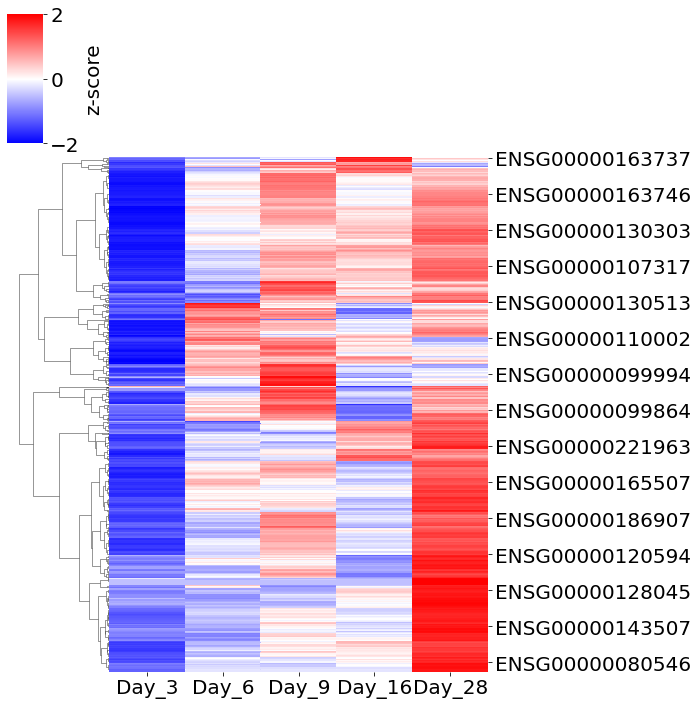

In [14]:
linkage_method = 'complete'
distance_metric = 'cosine'

g = seaborn.clustermap(up, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric, yticklabels = 40, cbar_kws={'label':'z-score'})

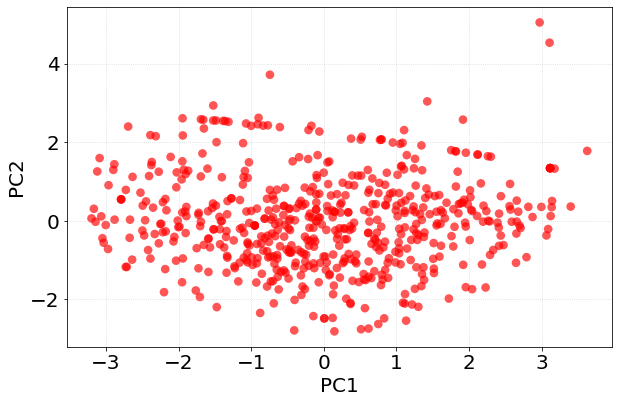

In [15]:
x = up.values
x = sklearn.preprocessing.StandardScaler().fit_transform(x)

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']
    matplotlib.pyplot.scatter(posx, posy, s=75, c='red', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 0.451194
[t-SNE] KL divergence after 250 iterations with early exaggeration: 8.615093
[t-SNE] KL divergence after 1000 iterations: 0.729551


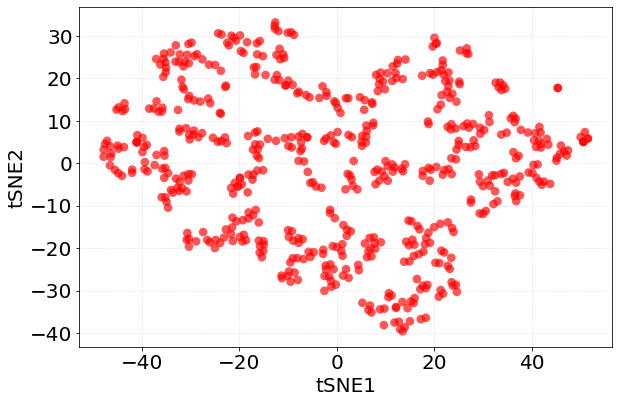

In [16]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='euclidean', early_exaggeration=3, method='exact').fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = embedding[i][0]
    posy = embedding[i][1]
    matplotlib.pyplot.scatter(posx, posy, s=75, c='red', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

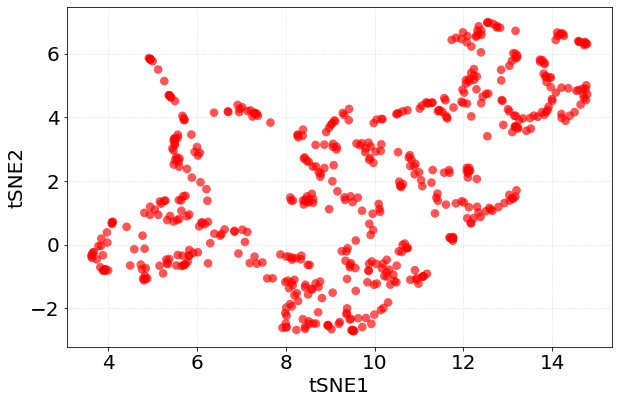

In [17]:
reducer = umap.UMAP(metric='euclidean', n_neighbors=10, min_dist=0.1)
umap_embedding = reducer.fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = umap_embedding[i][0]
    posy = umap_embedding[i][1]
    matplotlib.pyplot.scatter(posx, posy, s=75, c='red', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 4.2. upregulated genes

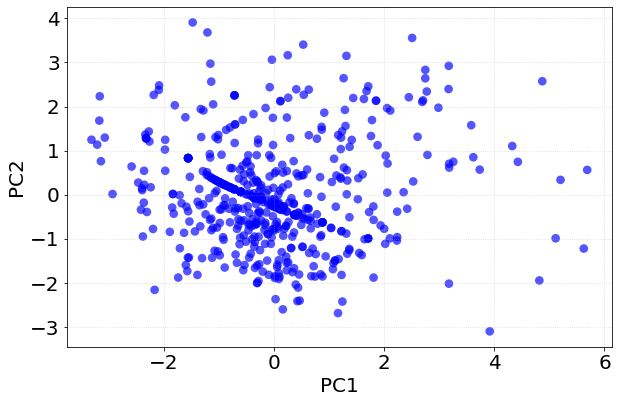

In [18]:
x = down.values
x = sklearn.preprocessing.StandardScaler().fit_transform(x)

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']
    matplotlib.pyplot.scatter(posx, posy, s=75, c='blue', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 520 / 520
[t-SNE] Mean sigma: 0.357215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 7.774948
[t-SNE] KL divergence after 1000 iterations: 0.616996


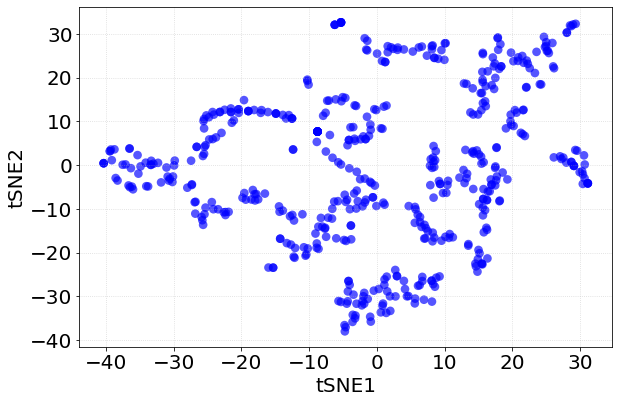

In [19]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='euclidean', early_exaggeration=3, method='exact').fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = embedding[i][0]
    posy = embedding[i][1]
    matplotlib.pyplot.scatter(posx, posy, s=75, c='blue', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

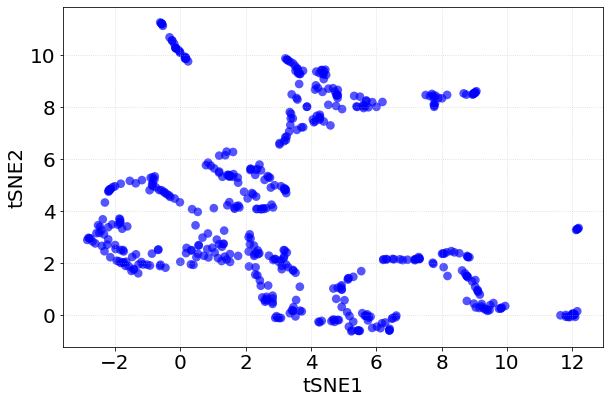

In [20]:
reducer = umap.UMAP(metric='euclidean', n_neighbors=10, min_dist=0.1)
umap_embedding = reducer.fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))
for i in principal_df.index:
    posx = umap_embedding[i][0]
    posy = umap_embedding[i][1]
    matplotlib.pyplot.scatter(posx, posy, s=75, c='blue', alpha=2/3, ec=None)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()